In [1]:
import sys
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import random as python_random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(40) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(40)

# Load the Data

In [3]:
HOLD_dir = "dl_data_2/HOLD_data"
test_dir = "dl_data_2/dl_data"
class_names = ['Covid', 'Normal', 'Viral']

batch_size = 8;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 244; 
img_width = 244;

img_height_dense = 224; 
img_width_dense = 224;

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 40,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Holdout Dataset
HOLD_ds = tf.keras.preprocessing.image_dataset_from_directory(
    HOLD_dir,
    seed = 40,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Test Dataset DENSE
test_ds_dense = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 40,
    image_size= (img_height_dense, img_width_dense),
    batch_size = batch_size
)

# Holdout Dataset DENSE
HOLD_ds_dense = tf.keras.preprocessing.image_dataset_from_directory(
    HOLD_dir,
    seed = 40,
    image_size= (img_height_dense, img_width_dense),
    batch_size = batch_size
)

Found 13633 files belonging to 3 classes.
Using 2726 files for validation.
Found 1514 files belonging to 3 classes.
Found 13633 files belonging to 3 classes.
Using 2726 files for validation.
Found 1514 files belonging to 3 classes.


# Functions

In [37]:
thresh_range = [(x/10000) for x in range(0,10000)]

def pr_curve(predictions, labels, save_path=None, save_period=None):
    # for each threshold value calculate precision and recal
    results = pd.DataFrame(columns=['threshold', 'accuracy', 'precision', 'recall', 'sensitivity', 'F1-score'])
    for i, t in enumerate(thresh_range):
        th, ac, pr, rc, sen, f1 = calc_prec_recall(t,predictions, labels)
        results = pd.concat([results,pd.DataFrame.from_dict({'threshold': [th],'accuracy': [ac],'precision': [pr],'recall': [rc], 'sensitivity': [sen], 'F1-score': [f1]})])
        if(save_period is not None and i%save_period == 0): # saves periodically
            results.to_csv(save_path, index=False)
            
    if(save_path is not None): # save at the end
        results.to_csv(save_path, index=False)
    return(results)

def building_blocks(threshold_value, predictions, labels):
    # for this function we will consolidate classes
    # we only want to compare the target class to the non-target class
    # Covid_img is our target class (true values) and  Normal_img  Viral_img are our other classes (false values)
    # class 0 indicates Covid
    pos = 0
    neg = 0
    tp = 0 # true positive
    fp = 0 # false positive
    tn = 0 # true negative
    fn = 0 # false negative
    for i, p in enumerate(predictions):
        if p[0] > threshold_value: # positive
            if labels[i] == 0: # positive
                pos += 1
                tp += 1
            else: # negative
                neg += 1
                fp += 1
        else: # negative
            if labels[i] == 0: # positive
                pos += 1
                fn += 1
            else: # negative
                neg += 1
                tn += 1

    return(threshold_value, tp, fp, tn, fn, pos, neg)

def calc_prec_recall(threshold_value ,predictions, labels):
    threshold, tp, fp, tn, fn, p, n = building_blocks(threshold_value, predictions, labels)
    
    # accuracy
    accuracy = (tp + tn) / (tp + tn +fp + fn)
    
    # precision
    precision = tp/(tp + fp + 0.000000000001)
    
    # recall aka sensativity
    recall = tp/p
    
    # specificity
    specificity = tn/n
    
    # f1-score
    f1 = 2* (precision * recall) / (precision + recall + 0.000000000000001)
    
    return(threshold, accuracy, precision, recall, specificity, f1)

def adj_class(arr, threshold):
    new_pred = []
    for a in arr:
        if(a[0]>threshold):
            new_pred = np.append(new_pred,0)
        else:
            new_pred = np.append(new_pred,np.argmax(a))
    return(new_pred)

def vote(arr):
    class_0 = len([x for x in arr if x==0])
    class_1 = len([x for x in arr if x==1])
    class_2 = len([x for x in arr if x==2])
    
    return(np.argmax([class_0,class_1,class_2]))

# Model 1: Resnet

### 1. Find the ideal Threshold
We want to select a threshold that maximizes COVID-19 true positives and minimizes false negatives. To find the threshold we need to do this on test data.

In [6]:
import zipfile
with zipfile.ZipFile('/home/hso6b/DL/saved_models/model_ROUND3_part2.zip', 'r') as zip_ref:
    zip_ref.extractall('/home/hso6b/DL/saved_models/model_ResNet')

In [11]:
# load model

# rn_model has class weighting in the training, model_RECALL does not
saved_model_1 = tf.keras.models.load_model('/home/hso6b/DL/saved_models/model_ResNet/model_ROUND3_part2')
predictions_1 = saved_model_1.predict(test_ds)

In [12]:
# saved_model_1.predict_classes()
predictions_1

array([[2.0558538e-02, 2.8370447e-05, 9.7941315e-01],
       [6.4312562e-02, 9.3566132e-01, 2.6123174e-05],
       [1.4756829e-05, 9.9989271e-01, 9.2460847e-05],
       ...,
       [2.6062212e-04, 9.9963343e-01, 1.0591199e-04],
       [5.0500653e-09, 1.0000000e+00, 5.2029727e-09],
       [3.1900670e-02, 9.6658373e-01, 1.5155497e-03]], dtype=float32)

In [13]:
np.sum(predictions_1, axis=0)

array([ 739.60333, 1606.687  ,  379.7101 ], dtype=float32)

In [14]:
# pull in label values
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())

In [15]:
# calculate precision and recall,then select the right threshold
results_1 = pr_curve(predictions_1, np.concatenate(y_true), save_path='model_1.csv', save_period=100)
test_results_ResNet = results_1.sort_values(['precision','recall'], ascending=False)
test_results_ResNet.head(1)

,threshold,accuracy,precision,recall,sensitivity,F1-score
0,0.9996,0.728173,0.295652,0.1051,0.922078,0.155074


In [16]:
y_true_adj = [x if x in [0,1] else 1 for x in np.concatenate(y_true)]
predictions_1_adj = [x[0] for x in predictions_1] # just the first class

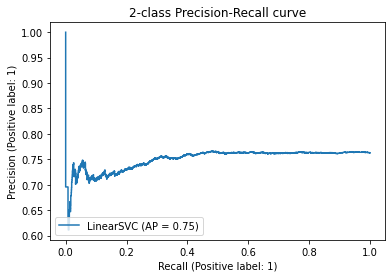

In [18]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_true_adj, predictions_1_adj, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

### 2. After finding an ideal threshold, we assign any class that's over the threshold for COVID-19 to the COVID class

In [19]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
threshold_1 = 0.9996 # threshold should be determined on test data not holdout
adj_pred_1 = adj_class(predictions_1, threshold_1)

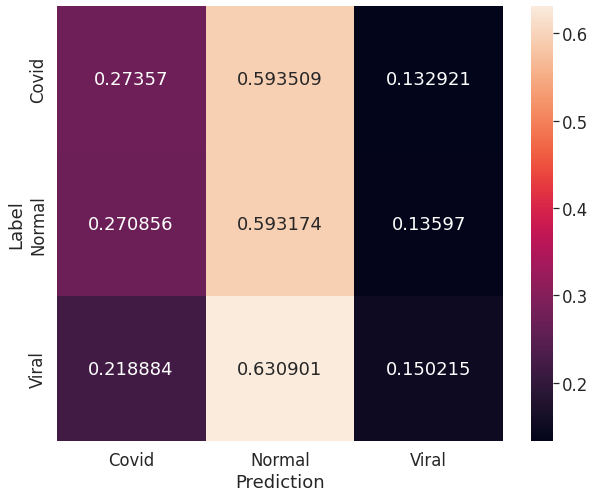

In [26]:
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())
y_true

# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    adj_pred_1,
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.5)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix1.png')
plt.show()

# Model 2: VGGNet

### 1. Find the ideal Threshold
We want to select a threshold that maximizes COVID-19 true positives and minimizes false negatives. To find the threshold we need to do this on test data.

In [21]:
# load model
saved_model_2 = tf.keras.models.load_model('./saved_models/model_VGG_v2')
predictions_2 = saved_model_2.predict(test_ds)

In [22]:
predictions_2

array([[9.4413898e-35, 1.0000000e+00, 1.7740013e-24],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [3.4980454e-16, 1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [23]:
np.sum(predictions_2, axis=0)

array([1022.2105 , 1576.3173 ,  127.47199], dtype=float32)

In [25]:
# calculate precision and recall,then select the right threshold
results_2 = pr_curve(predictions_2, np.concatenate(y_true), save_path='model_2.csv', save_period=100)
test_results_VGGNet = results_2.sort_values(['precision','recall'], ascending=False)
test_results_VGGNet.head(1)

,threshold,accuracy,precision,recall,sensitivity,F1-score
0,0.0,0.425899,0.23861,0.647604,0.356902,0.348731


### 2. After finding an ideal threshold, we assign any class that's over the threshold for COVID-19 to the COVID class

In [27]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
threshold_2 = 0.000001 # threshold should be determined on test data not holdout
adj_pred_2 = adj_class(predictions_2, threshold_2)

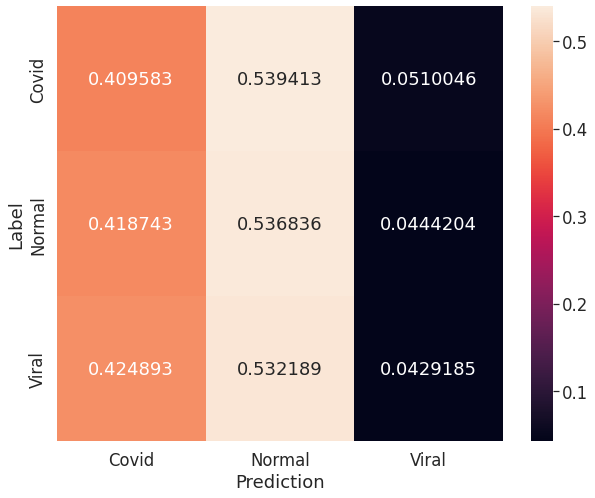

In [28]:
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())
y_true

# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    adj_pred_2,
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.5)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix2.png')
plt.show()

# Model 3: DenseNet

### 1. Find the ideal Threshold
We want to select a threshold that maximizes COVID-19 true positives and minimizes false negatives. To find the threshold we need to do this on test data.

In [29]:
import zipfile
with zipfile.ZipFile('/home/hso6b/DL/saved_models/model_Dense_2.zip', 'r') as zip_ref:
    zip_ref.extractall('/home/hso6b/DL/saved_models/model_DenseNet')

In [33]:
# load model
saved_model_3 = tf.keras.models.load_model('/home/hso6b/DL/saved_models/model_DenseNet')
predictions_3 = saved_model_3.predict(test_ds_dense)

In [34]:
predictions_3

array([[0.02315408, 0.7037023 , 0.2731437 ],
       [0.7389255 , 0.06447729, 0.19659719],
       [0.5426322 , 0.1475856 , 0.30978218],
       ...,
       [0.40069082, 0.31984252, 0.27946666],
       [0.738763  , 0.1354098 , 0.12582722],
       [0.52726555, 0.12825891, 0.34447557]], dtype=float32)

In [35]:
np.sum(predictions_3, axis=0)

array([1325.9478,  681.546 ,  718.5047], dtype=float32)

In [38]:
# calculate precision and recall,then select the right threshold
results_3 = pr_curve(predictions_3, np.concatenate(y_true), save_path='model_3.csv', save_period=100)
test_results_DenseNet = results_3.sort_values(['precision','recall'], ascending=False)
test_results_DenseNet.head(1)

,threshold,accuracy,precision,recall,sensitivity,F1-score
0,0.9463,0.760455,0.333333,0.009274,0.994228,0.018045


### 2. After finding an ideal threshold, we assign any class that's over the threshold for COVID-19 to the COVID class

In [39]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
threshold_3 = 0.9463 # threshold should be determined on test data not holdout
adj_pred_3 = adj_class(predictions_3, threshold_3)

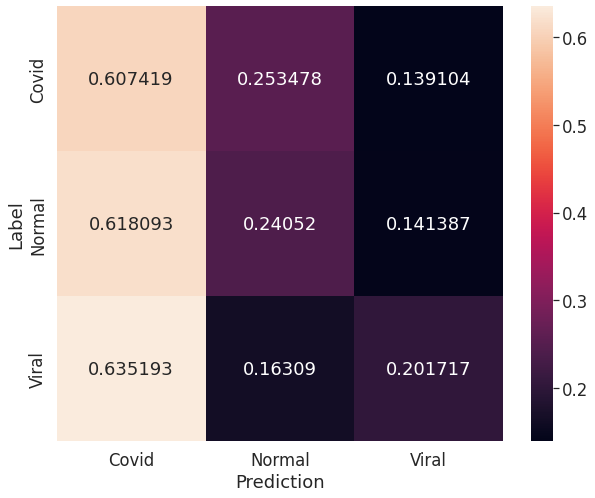

In [41]:
# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    adj_pred_3,
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.5)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix3.png')
plt.show()

# Combine the predictions

In [42]:
# Prediction on holdout data, now that we have the threshold selected
HOLD_predictions_1 = saved_model_1.predict(HOLD_ds)
HOLD_predictions_2 = saved_model_2.predict(HOLD_ds)
HOLD_predictions_3 = saved_model_3.predict(HOLD_ds_dense)

In [43]:
HOLD_adj_pred_1 = adj_class(HOLD_predictions_1, threshold_1)
HOLD_adj_pred_2 = adj_class(HOLD_predictions_2, threshold_2)
HOLD_adj_pred_3 = adj_class(HOLD_predictions_3, threshold_3)

max_pred = np.dstack([HOLD_adj_pred_1,HOLD_adj_pred_2,HOLD_adj_pred_3])[0]

In [44]:
max_pred = [vote(x) for x in max_pred]
len(max_pred)

1514

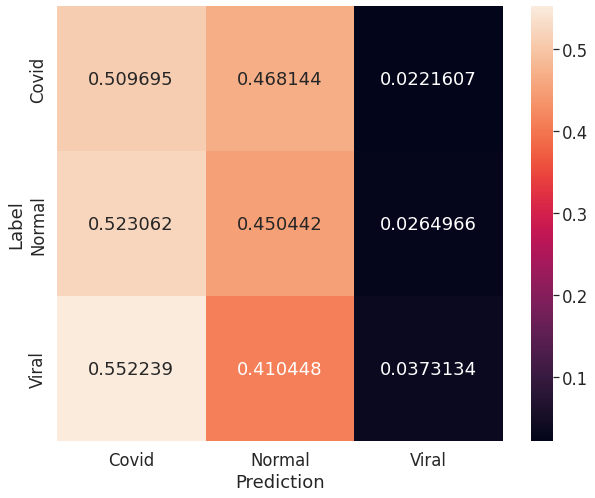

In [47]:
y_true_hold = []
for img, label in HOLD_ds:
    y_true_hold.append(label.numpy())
y_true_hold

# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true_hold),
    max_pred,
    num_classes=3,
    weights=None) # change to get to 100% covid accuracy
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.5)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix_comb.png')
plt.show()